This notebook is an attempt to figure out a good angstrom coefficient or aod value to use to process the Kamchatka day-of remobilization event.

For the Kamchatka event, we have clear images on the day before, the day of, and the day after the event:

| Description | Day of year | File Name |
|:-:|:-:|:-:|
| Day before | 258 | A2015258013500 |
| Day of | 259 | A2015259022000 |
| Day after | 260 | A2015260012500 |

# Loading satellite data

In [5]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline

Setting file paths:

In [6]:
fileDir = 'C:/Users/cmitchell/SHARE/satellieFiles/volcano/'
kamchatka258File = 'A2015258013500.L2'
#kamchatka258File = 'A2015259022000.L2'

Loading file:

In [7]:
kamchatka258 = xr.load_dataset(fileDir+kamchatka258File,group='geophysical_data')
kamchatka258_nav = xr.load_dataset(fileDir+kamchatka258File,group='navigation_data')
#kamchatka258 = xr.merge([kamchatka258,kamchatka258_nav])

# Wrangling data

I've been having problems with the Kamchatka-258 file because it has some data overlapping the international date line:

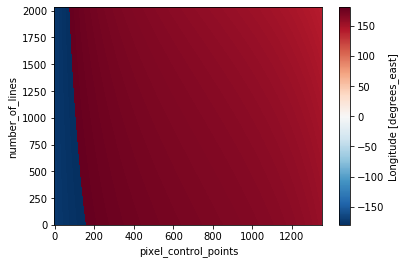

In [4]:
kamchatka258_nav.longitude.plot()

I'm going to set the data to NaN for the pixels across the international date line. Note, to do this, I AM NOT setting the longitude values to NaN (the mapping functions don't like that), I am setting the geophysical data to NaN.

In [8]:
ind = kamchatka258_nav.longitude.data < 0
kamchatka258 = xr.where(ind,np.nan,kamchatka258)

I want to subscene the data, so I can be consistent over the area which I am studying. My limits are:

- North: 58N
- South: 52N
- East: 168E
- West: 159E

How do I subscene?

## Plotting (and mapping) a subscene

In [6]:
plotData = kamchatka258.angstrom.data
lats = kamchatka258_nav.latitude.data
lons = kamchatka258_nav.longitude.data
plotData[lons<0] = np.nan

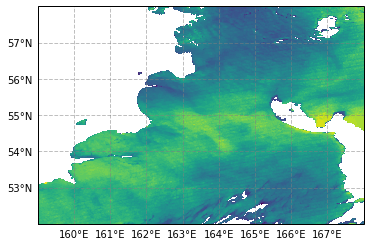

In [20]:
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, plotData, 60,
             transform=ccrs.PlateCarree())

# Set lat and long limits here
ax.set_extent([159,168,52,58])

#doing the gridlines, haven't figured out how to
#do the xticks neatly, so for now, I'm keeping the 
#grey gridlines on the image
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

The above is just plotting the data using the limits I specify - it isn't actually creating a new DataSet with the subscened data

## Subscening the data within the DataSet

I think I want to do this on the non-mapped data - it's the rawest form of the data.

First, let's define the limits:

In [9]:
lonE = 168
lonW = 159
latN = 58
latS = 52

Making the index array:

In [10]:
lats = kamchatka258_nav.latitude.data
lons = kamchatka258_nav.longitude.data

lon_idx = (lons < lonE) & (lons > lonW)
lat_idx = (lats < latN) & (lats > latS)
latlon_idx = lon_idx & lat_idx

Subsetting the DataSet

In [11]:
kam258 = kamchatka258.where(latlon_idx)

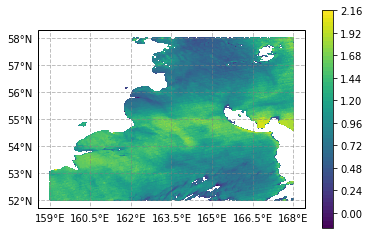

In [51]:
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, kam258.angstrom.data, 60,
             transform=ccrs.PlateCarree())

# Set lat and long limits here
#ax.set_extent([159,168,52,58])

#doing the gridlines, haven't figured out how to
#do the xticks neatly, so for now, I'm keeping the 
#grey gridlines on the image
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.colorbar()

OK this seems to have worked

# Analysis of Angstrom Coefficient and AOT(869)

C:\Users\cmitchell\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\cmitchell\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


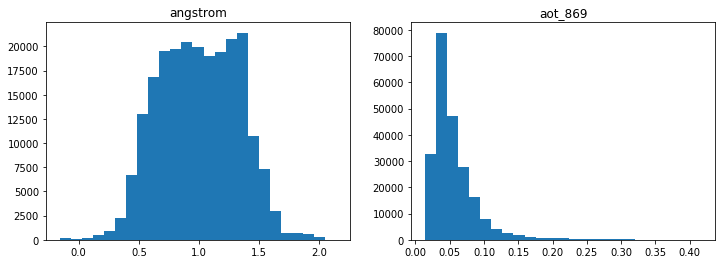

In [12]:
variables = ['angstrom','aot_869']

fig,ax = plt.subplots(1,2,figsize=(12,4))
for ai,vv in zip(ax,variables):
    DATA = kam258[vv]
    ai.hist(DATA.data.flatten(),bins=25)
    ai.set_title(vv)

Note the difference in the distribution of these values - when doing the stats, I think the geometric mean is more appropriate for aot_869, but not for the angstrom coefficient (especially since it has negative values).

In [13]:
statistics = {}
for vv in variables:
    DATA = kam258[vv]
    
    statistics[vv] = [np.nanmin(DATA),np.nanmax(DATA),np.nanmedian(DATA),np.nanmean(DATA),
                np.nanstd(DATA),stats.mstats.gmean(DATA.data.flatten()[~np.isnan(DATA.data.flatten())])]
    
statistics = pd.DataFrame.from_dict(statistics,orient='index',columns=['min','max','median','mean','stdev','geo mean'])

C:\Users\cmitchell\anaconda3\lib\site-packages\scipy\stats\stats.py:332: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


In [14]:
statistics

,min,max,median,mean,stdev,geo mean
angstrom,-0.1586,2.1433,1.0014,1.001192,0.328112,NaN
aot_869,0.0138,0.4173,0.0461,0.056592,0.036523,0.049196


# What to use for atmospheric correction processing?

I can either select a run that uses 

1. a constant angstrom coefficient (`aer_opt = -7`) OR 
2. fixed aot across the visible and NIR spectrum (`aer_opt = -8`)

I can easily do option 1 above, and use the median value.

However, I only have aot at 869 nm... what about the other wavelengths? In the NASA Atmospheric Correction Document it states:

*For all else held fixed, the aerosol optical thickness at wavelength $\lambda$ is approximately related to the value at a reference wavelength $\lambda_0$ by*
$$\frac{\tau_a(\lambda)}{\tau_a(\lambda_0)}=\left(\frac{\lambda_0}{\lambda}\right)^{\alpha}$$
*The parameter $\alpha$ is known as the Angstrom coefficient. Smaller (larger) particles generally have a larger (smaller) Angstrom exponent.*

Therefore, I can estimate aot at the other wavelengths:

In [71]:
wavelengths = np.array([412,443,469,488,531,547,555,645,667,678,748,859,869])

aot_869 = 0.049
ang = 1.001

aot = ((wavelengths/869.)**ang)*aot_869

In [72]:
aot

array([0.02321397, 0.02496246, 0.02642903, 0.02750081, 0.02992657,
       0.03082922, 0.03128056, 0.03635855, 0.03759995, 0.03822066,
       0.04217089, 0.04843557, 0.049     ])

# Different atmospheric correction results

I've tested:

1. The default atmospheric correction option
2. A constant angstrom coeff of 1.001
3. Constant aots as given above - note I'm not 100% sure this option is working correctly, because I can't find anywhere how to specify what wavelengths I am giving it...

How do these look?

In [15]:
file_default = 'A2015259022000.L2'
file_ang = 'A2015259022000_ang1-001.L2'
file_aot = 'A2015259022000_aot0-049.L2'

fileList = {'default' : file_default,'ang' : file_ang,'aot' :file_aot}

In [16]:
lonE = 168
lonW = 159
latN = 58
latS = 54

In [17]:
geophys = {}
nav = {}
for key,file in fileList.items():
    geophys[key] = xr.load_dataset(fileDir+file,group='geophysical_data')
    nav[key] = xr.load_dataset(fileDir+file,group='navigation_data')

## angstrom coefficient

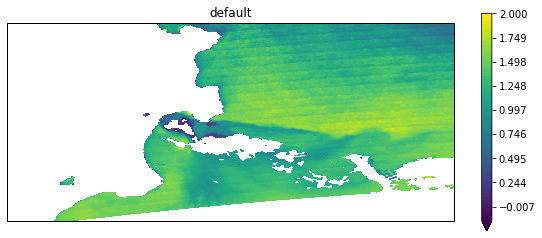

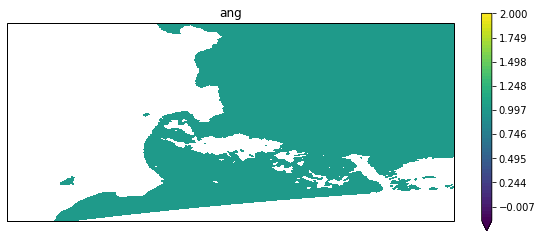

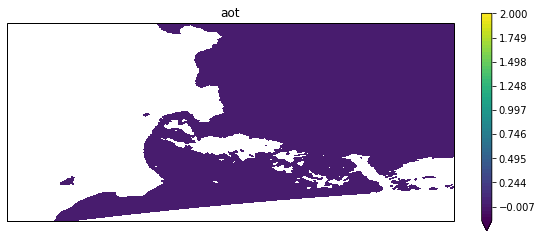

In [30]:
for ix,fileID in enumerate(fileList.keys()):
    fig = plt.figure(figsize=(10,4))
    
    GP = geophys[fileID]
    NV = nav[fileID]
    
    plotData = GP.angstrom.data
    lats = NV.latitude.data
    lons = NV.longitude.data
    plotData[lons<0] = np.nan

    ax = plt.axes(projection=ccrs.PlateCarree())
    
    vmin = -0.15
    vmax = 2
    levels = np.linspace(vmin,vmax,61)
    p1 = plt.contourf(lons, lats, plotData, levels,vmin=vmin,vmax=vmax,
                 transform=ccrs.PlateCarree(),extend='min')

    # Set lat and long limits here
    ax.set_extent([lonE,lonW,latS,latN])
    
    ax.set_title(fileID)
    
    plt.colorbar(p1)
    
    plt.savefig('angstrom_'+fileID+'.png',dpi=300)

## aot

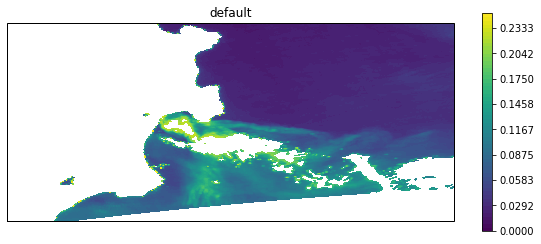

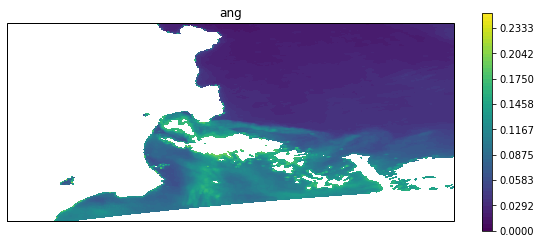

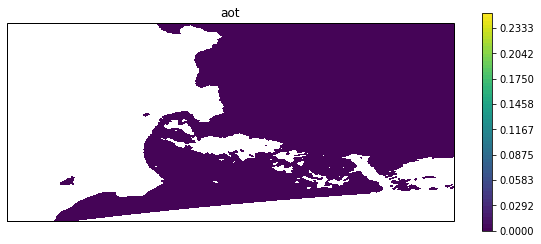

In [31]:
for ix,fileID in enumerate(fileList.keys()):
    fig = plt.figure(figsize=(10,4))
    
    GP = geophys[fileID]
    NV = nav[fileID]
    
    plotData = GP.aot_869.data
    lats = NV.latitude.data
    lons = NV.longitude.data
    plotData[lons<0] = np.nan

    ax = plt.axes(projection=ccrs.PlateCarree())
    
    vmin = 0
    vmax = 0.25
    levels = np.linspace(vmin,vmax,61)
    p1 = plt.contourf(lons, lats, plotData, levels,vmin=vmin,vmax=vmax,
                 transform=ccrs.PlateCarree())

    # Set lat and long limits here
    ax.set_extent([lonE,lonW,latS,latN])
    
    ax.set_title(fileID)
    plt.colorbar(p1)
    
    plt.savefig('aot869_'+fileID+'.png',dpi=300)

## chl

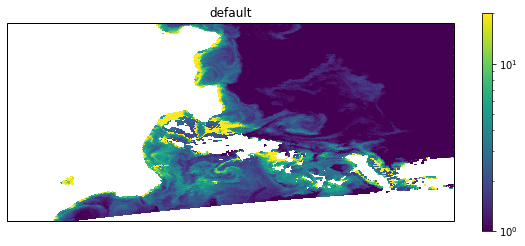

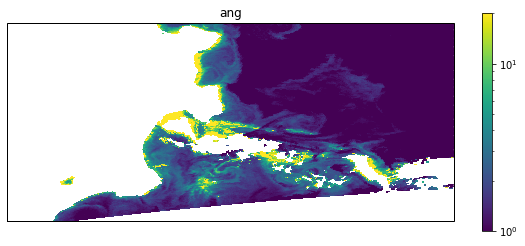

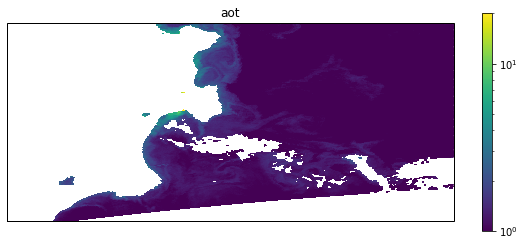

In [32]:
for ix,fileID in enumerate(fileList.keys()):
    fig = plt.figure(figsize=(10,4))
    
    GP = geophys[fileID]
    NV = nav[fileID]
    
    plotData = GP.chlor_a.data
    lats = NV.latitude.data
    lons = NV.longitude.data
    plotData[lons<0] = np.nan

    ax = plt.axes(projection=ccrs.PlateCarree())
    
    norm= colors.LogNorm(vmin=1, vmax=20)

    plt.pcolormesh(lons, lats, plotData, 
                 transform=ccrs.PlateCarree(),norm=norm)
    
    # Set lat and long limits here
    ax.set_extent([lonE,lonW,latS,latN])
    ax.set_aspect('equal')
    
    ax.set_title(fileID)
    plt.colorbar()
    
    plt.savefig('chl_'+fileID+'.png',dpi=300)

So we are getting quite different answers here! I'm still dubious about the correction with a constant aot... but if you look at the aot results for the default and constant angstrom correction methods, there is a hard line at the edge of the plume. Perhaps the method should be to take the average angstrom coefficient from that day over an area adjacent to the plume? 

What is the difference in the chl product for the different methods?

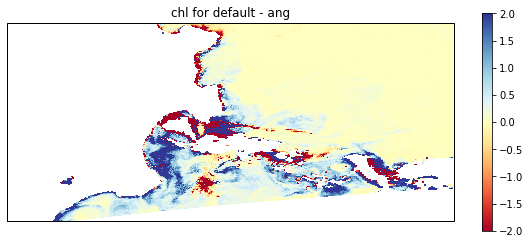

In [39]:
plt.figure(figsize=(10,4))
plotData = geophys['default'].chlor_a.data - geophys['ang'].chlor_a.data
lats = nav['default'].latitude.data
lons = nav['default'].longitude.data
plotData[lons<0] = np.nan

ax = plt.axes(projection=ccrs.PlateCarree())

#norm= colors.LogNorm(vmin=1, vmax=20)

plt.pcolormesh(lons, lats, plotData,vmin=-2,vmax=2,
             transform=ccrs.PlateCarree(),cmap = 'RdYlBu')

# Set lat and long limits here
ax.set_extent([lonE,lonW,latS,latN])
ax.set_title('chl for default - ang')
plt.colorbar()

plt.savefig('chldiff_default-ang.png',dpi=300)

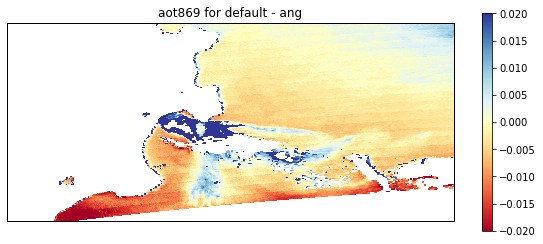

In [42]:
plt.figure(figsize=(10,4))
plotData = geophys['default'].aot_869.data - geophys['ang'].aot_869.data
lats = nav['default'].latitude.data
lons = nav['default'].longitude.data
plotData[lons<0] = np.nan

ax = plt.axes(projection=ccrs.PlateCarree())

#norm= colors.LogNorm(vmin=1, vmax=20)

plt.pcolormesh(lons, lats, plotData,vmin=-0.02,vmax=0.02,
             transform=ccrs.PlateCarree(),cmap = 'RdYlBu')

# Set lat and long limits here
ax.set_extent([lonE,lonW,latS,latN])
ax.set_title('aot869 for default - ang')
plt.colorbar()

plt.savefig('aotdiff_default-ang.png',dpi=300)

## Conclusion

I don't think the above has worked that well, because the issue is that the aerosols have changed, so using the angstrom or aot from the day before isn't the best approach. In fact, what the above shows me is the default correction is identifying something in the atmosphere, but whether it is fully removing it is questionable. Additionally, it seems using the default correction, the aot is thicker in the plume compared to setting the angstrom coefficient in the way I did. So while I still think in theory, you could set a different angstrom to make a thicker atmosphere, it's hard to do it objectively.